### Census Demographic Data
OOO: 
1. Write function to pull census data using the census API
2. Identify Census table codes for demographic data: Race, Income, Education, Employment
3. Pull data for census tracts in NYC
4. Pull in NYC neighborhood boundaries
5. Areal Interpolation to aggregate tract-level census data to neighborhood level
6. Write out neighborhood-level data to csv

In [2]:
## set up 
import numpy as np
import matplotlib.pyplot as plt
from census import Census
import pandas as pd
import geopandas as gpd
import os
from shapely import wkt
# set census API
c = Census("6ac387b0502d560fc46b0a76bbc7865b6354c7de")


In [3]:
# # test out the census api function
# pd.DataFrame(
#     c.acs5.state_county_tract(
#     fields = "B02001_001E",
#     state_fips = "36", # NY
#     county_fips ="005", # NY
#     tract = "*",
#     year = 2020)
# ).head()

## test median income table
pd.DataFrame(
    c.acs5.state_county_tract(
    fields = "B06011_001E", # total median income by place of birth (Total)
    state_fips = "36", # NY
    county_fips ="005", # NY
    tract = "*",
    year = 2020)
).head()

,B06011_001E,state,county,tract
0,24966.0,36,005,019900
1,22348.0,36,005,020000
2,20833.0,36,005,020100
3,22083.0,36,005,020200
4,28991.0,36,005,020400


In [4]:
# dict of table names
estimates_dict = {
    "B02001_001E": "Total Estimate",
    "B02001_002E": "White alone Estimate",
    "B02001_003E": "Black or African American alone Estimate",
    "B02001_004E": "American Indian and Alaska Native alone Estimate",
    "B02001_005E": "Asian alone Estimate",
    "B02001_006E": "Native Hawaiian and Other Pacific Islander alone Estimate",
    "B02001_007E": "Some Other Race alone Estimate",
    "B02001_008E": "Two or More Races Estimate",
    "B02001_009E": "Two races including Some Other Race Estimate",
    "B02001_010E": "Two races excluding Some Other Race, and three or more races Estimate",
    "B06011_001E": "Median Income In The Past 12 Months (In 2020 Inflation-Adjusted Dollars)"
}

# list of table names
table_code = list(estimates_dict.keys())

# FIPS Codes for counties in NYC
fips_list = ["005", "047", "061", "081", "085"]

def pull_census(c, tables, fips_list):
    """
    Pulls census data for multiple counties in NYC.
    Parameters:
    c (Census): Census API client
    tables (list): List of table codes to fetch
    fips_list (list): List of FIPS codes for NYC counties
    Returns:
    pandas.DataFrame: Census data for the specified counties and tables
    """
    tract_data = pd.DataFrame()
    # Loop through each county
    for fip in fips_list:
        try:
            # Pull data for each county
            data = c.acs5.state_county_tract(
                fields=tables,
                state_fips="36",  # NY
                county_fips=fip,  # NY
                tract="*",
                year=2020
            )
        # if empty, skip
            if not data:
                continue
            # else convert to data frame
            data_df = pd.DataFrame(data)
            # then add converted json to empty tract_data dataframe
            tract_data = pd.concat([tract_data, data_df], ignore_index=True)
        except Exception as e:
            print(f"Error pulling data for {fip}: {e}")
    return tract_data




In [5]:
# test the function
# fips_list[0:2]
# tract_demo = pull_census(c, table_code, fips_list[0:2])
# tract_demo.head()
# run on all counties
tract_demo = pull_census(c, table_code, fips_list)
tract_demo.describe()

,B02001_001E,B02001_002E,B02001_003E,B02001_004E,B02001_005E,B02001_006E,B02001_007E,B02001_008E,B02001_009E,B02001_010E,B06011_001E
count,2327.000000,2327.000000,2327.000000,2327.000000,2327.000000,2327.000000,2327.000000,2327.000000,2327.000000,2327.000000,2.327000e+03
mean,3601.010743,1488.305114,857.808767,15.850451,514.508380,2.270305,519.629996,202.637731,99.299527,103.338204,-2.975813e+07
std,2025.087211,1464.628926,1121.039933,44.407303,720.419606,14.927209,756.988793,228.525534,158.398781,132.285116,1.377899e+08
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.666667e+08
25%,2192.500000,394.500000,55.000000,0.000000,62.000000,0.000000,66.000000,48.000000,2.000000,15.000000,2.444600e+04
50%,3363.000000,1095.000000,300.000000,0.000000,237.000000,0.000000,242.000000,140.000000,39.000000,64.000000,3.250000e+04
75%,4683.500000,2100.000000,1425.500000,12.000000,692.500000,0.000000,625.000000,281.000000,125.000000,143.000000,4.282900e+04
max,16600.000000,11625.000000,7248.000000,971.000000,7974.000000,405.000000,6090.000000,2344.000000,1602.000000,1949.000000,2.047500e+05


In [6]:
# use the table codes list to rename the columns
tract_demo = tract_demo.rename(columns=estimates_dict)
tract_demo.head()

,Total Estimate,White alone Estimate,Black or African American alone Estimate,American Indian and Alaska Native alone Estimate,Asian alone Estimate,Native Hawaiian and Other Pacific Islander alone Estimate,Some Other Race alone Estimate,Two or More Races Estimate,Two races including Some Other Race Estimate,"Two races excluding Some Other Race, and three or more races Estimate",Median Income In The Past 12 Months (In 2020 Inflation-Adjusted Dollars),state,county,tract
0,7937.0,1226.0,3143.0,0.0,0.0,0.0,2959.0,609.0,426.0,183.0,24966.0,36,005,019900
1,4750.0,830.0,489.0,48.0,1320.0,26.0,1645.0,392.0,260.0,132.0,22348.0,36,005,020000
2,3887.0,482.0,1553.0,12.0,1.0,0.0,1710.0,129.0,129.0,0.0,20833.0,36,005,020100
3,2387.0,335.0,375.0,7.0,468.0,0.0,1110.0,92.0,26.0,66.0,22083.0,36,005,020200
4,3279.0,711.0,183.0,0.0,557.0,0.0,1454.0,374.0,255.0,119.0,28991.0,36,005,020400


In [7]:
# read nyc tracts from geojson url 
nyc_tracts = gpd.read_file("https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Census_Tracts_for_2020_US_Census/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson")

In [8]:
nyc_tracts.head()

,OBJECTID,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,PUMA,Shape__Area,Shape__Length,geometry
0,1,1,1,Manhattan,000100,1000100,None,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,4121,1.842846e+06,10832.203947,"MULTIPOLYGON (((-74.04388 40.6902, -74.04351 4..."
1,2,2.01,1,Manhattan,000201,1000201,None,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000201,4103,9.723121e+05,4754.495247,"POLYGON ((-73.9845 40.70952, -73.98655 40.7093..."
2,3,6,1,Manhattan,000600,1000600,None,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000600,4103,2.582705e+06,6976.286215,"POLYGON ((-73.99022 40.71441, -73.98934 40.714..."
3,4,14.01,1,Manhattan,001401,1001401,None,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001401,4103,1.006117e+06,5075.332000,"POLYGON ((-73.98837 40.71645, -73.98754 40.716..."
4,5,14.02,1,Manhattan,001402,1001402,None,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001402,4103,1.226206e+06,4459.156019,"POLYGON ((-73.98507 40.71909, -73.98423 40.718..."


In [9]:
# create geoid in census demo data to match nyc tracts
# first check out tract_demo.tract to see if they are zero padded
# tract_demo["tract"].values
# tract_demo.county.unique()
tract_demo["GEOID"] = tract_demo["state"] + tract_demo["county"] + tract_demo["tract"]
tract_demo.GEOID.head()

0    36005019900
1    36005020000
2    36005020100
3    36005020200
4    36005020400
Name: GEOID, dtype: object

In [10]:
# merge with nyc tracts
census_demo_tracts = nyc_tracts.merge(tract_demo, on="GEOID")

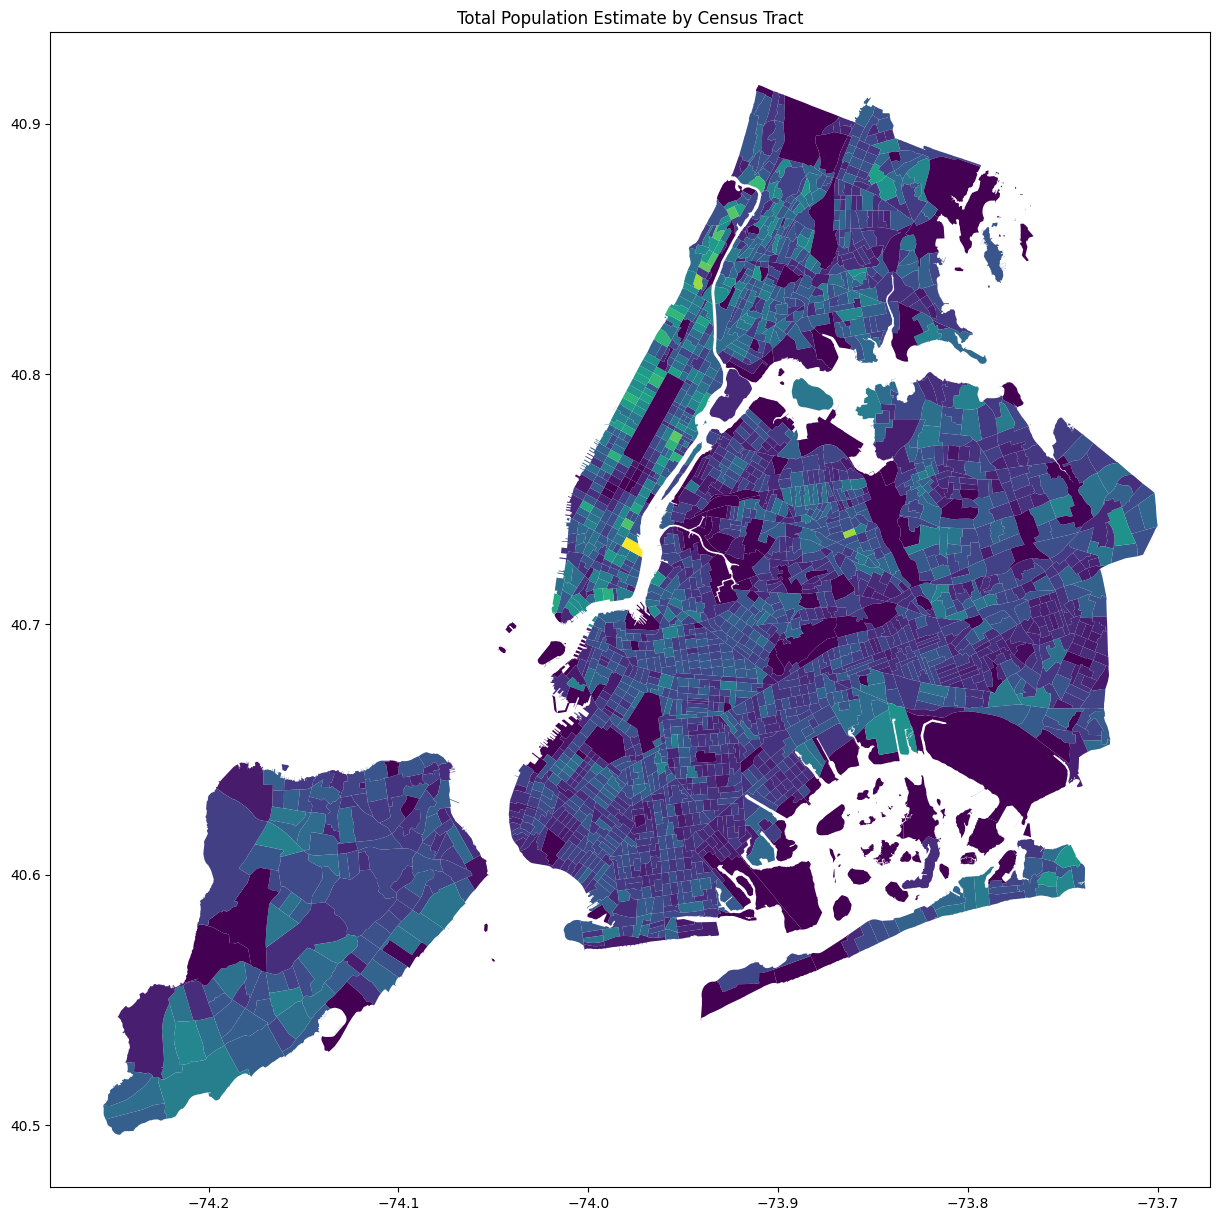

In [11]:
# plot total tract level estimate on a map just to see what we've got going on 
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
census_demo_tracts.plot(column="Total Estimate", ax=ax)
plt.title("Total Population Estimate by Census Tract")
plt.show()

In [12]:
print(census_demo_tracts.columns)
census_demo_tracts.head()

Index(['OBJECTID', 'CTLabel', 'BoroCode', 'BoroName', 'CT2020', 'BoroCT2020',
       'CDEligibil', 'NTAName', 'NTA2020', 'CDTA2020', 'CDTANAME', 'GEOID',
       'PUMA', 'Shape__Area', 'Shape__Length', 'geometry', 'Total Estimate',
       'White alone Estimate', 'Black or African American alone Estimate',
       'American Indian and Alaska Native alone Estimate',
       'Asian alone Estimate',
       'Native Hawaiian and Other Pacific Islander alone Estimate',
       'Some Other Race alone Estimate', 'Two or More Races Estimate',
       'Two races including Some Other Race Estimate',
       'Two races excluding Some Other Race, and three or more races Estimate',
       'Median Income In The Past 12 Months (In 2020 Inflation-Adjusted Dollars)',
       'state', 'county', 'tract'],
      dtype='object')


,OBJECTID,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,...,Asian alone Estimate,Native Hawaiian and Other Pacific Islander alone Estimate,Some Other Race alone Estimate,Two or More Races Estimate,Two races including Some Other Race Estimate,"Two races excluding Some Other Race, and three or more races Estimate",Median Income In The Past 12 Months (In 2020 Inflation-Adjusted Dollars),state,county,tract
0,1,1,1,Manhattan,000100,1000100,None,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,...,0.0,0.0,0.0,0.0,0.0,0.0,-666666666.0,36,061,000100
1,2,2.01,1,Manhattan,000201,1000201,None,Chinatown-Two Bridges,MN0301,MN03,...,754.0,0.0,514.0,987.0,838.0,149.0,18012.0,36,061,000201
2,3,6,1,Manhattan,000600,1000600,None,Chinatown-Two Bridges,MN0301,MN03,...,6123.0,0.0,1649.0,795.0,50.0,745.0,11455.0,36,061,000600
3,4,14.01,1,Manhattan,001401,1001401,None,Lower East Side,MN0302,MN03,...,393.0,0.0,55.0,111.0,5.0,106.0,56379.0,36,061,001401
4,5,14.02,1,Manhattan,001402,1001402,None,Lower East Side,MN0302,MN03,...,872.0,0.0,497.0,186.0,7.0,179.0,34512.0,36,061,001402


In [93]:
# drop unnneceesary columns, write out to csv
print(census_demo_tracts.columns)
census_demo_tracts.head()
# keep only relevant data
census_demo_tracts = census_demo_tracts[['GEOID', 'tract', 'NTA2020', 'NTAName', 'Total Estimate',
       'White alone Estimate', 'Black or African American alone Estimate',
       'American Indian and Alaska Native alone Estimate',
       'Asian alone Estimate',
       'Native Hawaiian and Other Pacific Islander alone Estimate',
       'Some Other Race alone Estimate', 'Two or More Races Estimate',
       'Two races including Some Other Race Estimate',
       'Two races excluding Some Other Race, and three or more races Estimate',
       'Median Income In The Past 12 Months (In 2020 Inflation-Adjusted Dollars)']]

Index(['GEOID', 'tract', 'NTA2020', 'NTAName', 'Total Estimate',
       'White alone Estimate', 'Black or African American alone Estimate',
       'American Indian and Alaska Native alone Estimate',
       'Asian alone Estimate',
       'Native Hawaiian and Other Pacific Islander alone Estimate',
       'Some Other Race alone Estimate', 'Two or More Races Estimate',
       'Two races including Some Other Race Estimate',
       'Two races excluding Some Other Race, and three or more races Estimate',
       'Median Income In The Past 12 Months (In 2020 Inflation-Adjusted Dollars)'],
      dtype='object')


In [97]:
# deal with missing data or flags
# when income < 0, replace
# df.loc[df["gender"] == "male", "gender"] = 1
census_demo_tracts.loc[census_demo_tracts["Median Income In The Past 12 Months (In 2020 Inflation-Adjusted Dollars)"] < 0,
    "Median Income In The Past 12 Months (In 2020 Inflation-Adjusted Dollars)"] = pd.NA


In [98]:
# write out to csv
census_demo_tracts.to_csv('data/census_demo.csv')